# Regression with Different Output Format under Various Data Conditions

In this experience, we test the following output format for regression task under several different data coditions.
- Numerical output
- Regression as classification (grid-out)

The data coditions include:
- Sparse (few data)
- Grouped
  - Biased (parallel data)
  - Completely different mode, uncorrelated data (cross)
  - Partially diversed (split)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "regression_test_2"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
def draw_func(func_in, x_min=-5, x_max=5, mark='r--', linewidth=1, label='func'):
    n_sample = 100
    X_func = np.linspace(x_min, x_max, n_sample).reshape(n_sample, 1)
    y_func = func_in(X_func)
    plt.plot(X_func, y_func, mark, linewidth=linewidth, label=label)

Generate polynomial data

In [4]:
poly_a1 = 5.0
# poly_a1 = -10.0 # 5.0
#
sin_a = 0.0
# sin_a = 10.0
sin_f = 0.1 # 0.2
#
def func_0(X): # Reference
    return 0.5 * X**3 + 0.5 * X**2 + (poly_a1)*X + 2 + sin_a*np.sin(2.0*np.pi*sin_f*X)
def func_1(X): # Variation 1: parellel
    return 0.5 * X**3 + 0.5 * X**2 + (poly_a1)*X + 30 + sin_a*np.sin(2.0*np.pi*sin_f*X)
def func_2(X): # Variation 2: cross
    return -0.5 * X**3 + 0.5 * X**2 + (poly_a1)*X + 30 + sin_a*np.sin(2.0*np.pi*sin_f*X)
def func_3(X): # Variation 3: slightly split
    return 0.3 * X**3 + 1.0 * X**2 + (poly_a1)*X + 15 + sin_a*np.sin(2.0*np.pi*sin_f*X)
def func_4(X): # Sine wave~
    return 0.5 * X**3 + 0.5 * X**2 + (poly_a1)*X + 2 + 20.0*np.sin(2.0*np.pi*sin_f*X) # 50.0

In [5]:
func_dict = dict()
#-----------------#
func_dict["f1"] = func_0
#-----------------#
# func_dict["f2"] = func_1
# func_dict["f2"] = func_2
func_dict["f2"] = func_3
# func_dict["f2"] = func_4
#-----------------#
func_dict["f3"] = func_4
#-----------------#

# Note: func_dict["f_avg"] depends on multiout_type and is calculated in each section of multiout_type

In [6]:
np.random.seed(42)
m = 100 # 50 # 100 # 200
m_train = m // 5 * 4
print("(m, m_train) = (%d, %d)" % (m, m_train))

# Input
is_gapped = True
# is_gapped = False
#
if not is_gapped:
    X_data = 10 * np.random.rand(m, 1) - 5 # Note: X is randomly sampled, so we don't need to shuffle the data again
else:
    X_data = np.concatenate( (np.linspace(-5.0, -2.0, m//2), np.linspace(2.0, 5.0, m-m//2)) )
    X_data = X_data.reshape((m,1))
    np.random.shuffle(X_data)

# Output, multiout_type in {1, 2, 3}
# multiout_type = 1      
multiout_type = 2 
# multiout_type = 3 
#
sid_data = np.ones((m,1), dtype=int) # subject id, default: 1
if multiout_type == 2:
    m_h = m // 2
    X_data_1 = X_data[:m_h]
    X_data_2 = X_data[m_h:]
    sid_data[:m_h] = 1 # id:1
    sid_data[m_h:] = 2 # id:2
    y_data_pure_1 = func_dict["f1"](X_data_1) 
    y_data_pure_2 = func_dict["f2"](X_data_2) 
    y_data_pure = np.vstack([y_data_pure_1, y_data_pure_2])
    print("y_data_pure.shape = %s" % str(y_data_pure.shape))
    # Average line
    func_dict["f_avg"] = ( lambda X: 0.5*func_dict["f1"](X) + 0.5*func_dict["f2"](X) )
    #
elif multiout_type == 3: # with "avg" line
    m_t = m // 3
    X_data_1 = X_data[:m_t]
    X_data_2 = X_data[m_t:(2*m_t)]
    X_data_3 = X_data[(2*m_t):]
    sid_data[:m_t]        = 1 # id:1
    sid_data[m_t:(2*m_t)] = 2 # id:2
    sid_data[(2*m_t):]    = 3 # id:3
    y_data_pure_1 = func_dict["f1"](X_data_1) 
    y_data_pure_2 = func_dict["f2"](X_data_2) 
    y_data_pure_3 = func_dict["f3"](X_data_3) 
    y_data_pure = np.vstack([y_data_pure_1, y_data_pure_2, y_data_pure_3])
    print("y_data_pure.shape = %s" % str(y_data_pure.shape))
    # Average line
    func_dict["f_avg"] = ( lambda X: (func_dict["f1"](X) + func_dict["f2"](X) + func_dict["f3"](X))/3.0 )
    #
else: # multiout_type == 1
    # Average line
    func_dict["f_avg"] = ( lambda X: 0.5*func_dict["f1"](X) + 0.5*func_dict["f2"](X) )
    y_data_pure = func_dict["f_avg"](X_data)

    
# Label (+noise)
n_stddev = 2.0
# n_stddev = 10.0
y_data = y_data_pure + np.random.randn(m, 1) * n_stddev
print("y_data.shape = %s" % str(y_data.shape))
# print("sid_data = %s" % str(sid_data))

(m, m_train) = (100, 80)
y_data_pure.shape = (100, 1)
y_data.shape = (100, 1)


In [7]:
# Method 1: simply slice
# X_train = X_data[:m_train]
# y_train = y_data[:m_train]
# X_valid = X_data[m_train:]
# y_valid = y_data[m_train:]

# Method 2: shuffle
from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid, sid_train, sid_valid = train_test_split(X_data, y_data, sid_data, test_size=0.2, random_state=42)

In [8]:
print(X_train.shape)
# print("sid_train = %s" % str(sid_train))

(80, 1)


In [9]:
def draw_normal_func(func_dict):
    if multiout_type != 1:
        draw_func(func_dict["f1"], mark='c:', label="f1")
        draw_func(func_dict["f2"], mark='r:', label="f2")
    if multiout_type == 3:
        draw_func(func_dict["f3"], mark='y:', label="f3")
    draw_func(func_dict["f_avg"], mark='m--', label="f_avg")

In [10]:
def draw_points(X, y, sid=None):
    if sid is None:
        plt.plot(X, y, "b.")
    else:
        plt.plot(X[sid==1], y[sid==1], "b.")
        plt.plot(X[sid==2], y[sid==2], "r.")
        plt.plot(X[sid==3], y[sid==3], "y.")

Saving figure training_data


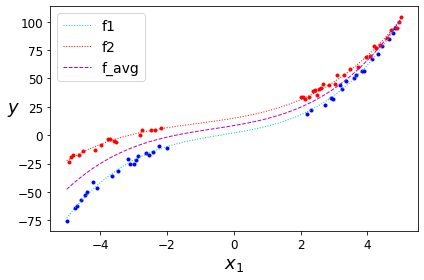

In [11]:
# plt.plot(X_train, y_train, "b.")
# plt.plot(X_train[sid_train==1], y_train[sid_train==1], "b.")
# plt.plot(X_train[sid_train==2], y_train[sid_train==2], "r.")
draw_points(X_train, y_train, sid_train)

draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
save_fig("training_data")
plt.show()

In [12]:
prediction_error_dict = dict()

def get_prediction_error(func_in, func_dict, name="", x_min=-5, x_max=5, prediction_error_dict=prediction_error_dict):
    n_sample = 100
    X_func = np.linspace(x_min, x_max, n_sample).reshape(n_sample, 1)
    y_func = func_in(X_func).reshape((n_sample,1))
    y_gt = func_dict["f_avg"](X_func).reshape((n_sample,1))
    print("y_func.shape = %s" % str(y_func.shape))
    print("y_gt.shape = %s" % str(y_gt.shape))
#     total_error = np.sqrt(np.square(y_func - y_gt).mean())
    total_error = np.abs(y_func - y_gt).mean()
    prediction_error_dict[name] = total_error
    return total_error

def print_all_prediction_error(is_logging_to_screen=True, prediction_error_dict=prediction_error_dict):
    _s = ""
    for _n in prediction_error_dict:
        _s += ("%s: %f" % (_n, prediction_error_dict[_n])) + "\n"
    if is_logging_to_screen:
        print(_s)
    return _s
        
def save_prediction_errors(is_logging_to_screen=False, prediction_error_dict=prediction_error_dict):
    path = os.path.join(IMAGES_PATH, "prediction_errors.txt")
    print("Saving all prediction errors to [%s]." % path)
    _s = print_all_prediction_error(is_logging_to_screen=is_logging_to_screen, prediction_error_dict=prediction_error_dict)
    with open(path, "w") as _f:
        _f.write(_s)
    return True

# Simple FCs (number --> number)

Build the regression model

In [13]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [14]:
# # Customized loss function
# def asymptoticLoss_fn(y_true, y_pred, alpha=0.01):
#     # tau: quantile, tau in [0.0, 1.0]
#     # y_true: label mean
#     # y_pred: predicted tau quantile
#     y_target = alpha * y_true + (1.0 - alpha) * y_pred
#     # return tf.abs(y_pred - y_target)
#     return (y_pred - y_target)**2

In [15]:
optimizer = keras.optimizers.SGD(lr=0.0001, momentum=0.9)
model.compile(loss="mean_squared_error", optimizer=optimizer)
# optimizer = keras.optimizers.Adam(lr=0.01)
# # model.compile(loss="mean_absolute_error", optimizer=optimizer)
# model.compile(loss=asymptoticLoss_fn, optimizer=optimizer)

C:\Users\benso\anaconda3\envs\ml\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

Epoch 1/100
3/3 [==============================] - 1s 88ms/step - loss: 2482.7036 - val_loss: 1687.5508
Epoch 2/100
3/3 [==============================] - 0s 20ms/step - loss: 2397.8794 - val_loss: 1602.8322
Epoch 3/100
3/3 [==============================] - 0s 16ms/step - loss: 2235.3794 - val_loss: 1435.3951
Epoch 4/100
3/3 [==============================] - 0s 27ms/step - loss: 1874.0433 - val_loss: 1046.3013
Epoch 5/100
3/3 [==============================] - 0s 34ms/step - loss: 999.3638 - val_loss: 511.6038
Epoch 6/100
3/3 [==============================] - 0s 23ms/step - loss: 626.2381 - val_loss: 1008.5215
Epoch 7/100
3/3 [==============================] - 0s 33ms/step - loss: 919.8281 - val_loss: 378.8942
Epoch 8/100
3/3 [==============================] - 0s 41ms/step - loss: 377.3785 - val_loss: 507.8655
Epoch 9/100
3/3 [==============================] - 0s 36ms/step - loss: 746.8472 - val_loss: 401.3120
Epoch 10/100
3/3 [==============================] - 0s 21ms/step - loss: 

Plot the result

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
save_fig("num_num_training_curve")
plt.show()

In [ ]:
# X_new = np.linspace(-5, 5, 100).reshape(100, 1)
# y_new = model.predict(X_new)
#
# plt.plot(X_train, y_train, "b.")
draw_points(X_train, y_train, sid_train)
# plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
draw_func(model.predict, mark='r-', linewidth=2, label="Predictions")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
save_fig("num_num_prediction")
plt.show()

In [ ]:
get_prediction_error(model.predict, func_dict, name="num-num")

# Simulated CNN Feature Map (1-D grids, grid --> number)

In [ ]:
class num2grid(keras.layers.Layer):
    def __init__(self, units, x_min=-10, x_max=10, sigma=1.0, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.x_min = x_min
        self.x_max = x_max
        self.sigma = sigma
        self.sigma2 = self.sigma**2
        self.activation = keras.activations.get(activation)
        
    def build(self, batch_input_shape):
        #
        self.x_grid = np.linspace(self.x_min, self.x_max, self.units, endpoint=True)
#         print("self.x_grid.shape = %s" % str(self.x_grid.shape))
        #
        super().build(batch_input_shape) # must be at the end
        
    def call(self, X):
        '''
        Input shape:  (batch, X_chanel)
        Output shape: (batch, grid_unit) 
        
        self.x_grid shape: (grid_unit,)
        '''
        gauss_grid = tf.exp( -(self.x_grid - X)**2 / (2.0*self.sigma2) )
        print("X.shape = %s" % str(X.shape))
        print("gauss_grid.shape = %s" % str(gauss_grid.shape))
        return self.activation(gauss_grid)
    
    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 
                "units": self.units,
                "x_min": self.x_min,
                "x_max": self.x_max,
                "sigma": self.sigma,
                "activation": keras.activations.serialize(self.activation)}

In [ ]:
model = keras.models.Sequential([
    num2grid(5,x_min=-10, x_max=10, sigma=3.0, input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
#     keras.layers.Dense(100, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(0.01)),
#     keras.layers.Dense(30, activation=keras.layers.LeakyReLU(alpha=0.2) ),
#     keras.layers.Dense(30, activation="selu"),
#     keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [ ]:
# # Customized loss function
# def asymptoticLoss_fn(y_true, y_pred, alpha=0.01):
#     # tau: quantile, tau in [0.0, 1.0]
#     # y_true: label mean
#     # y_pred: predicted tau quantile
#     y_target = alpha * y_true + (1.0 - alpha) * y_pred
#     # return tf.abs(y_pred - y_target)
#     return (y_pred - y_target)**2

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(loss="mean_squared_error", optimizer=optimizer)
# optimizer = keras.optimizers.Adam(lr=0.1)
# # model.compile(loss="mean_absolute_error", optimizer=optimizer)
# model.compile(loss=asymptoticLoss_fn, optimizer=optimizer)

In [ ]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
save_fig("grid_num_training_curve")
plt.show()

In [ ]:
# X_new = np.linspace(-5, 5, 100).reshape(100, 1)
# y_new = model.predict(X_new)
#
# plt.plot(X_train, y_train, "b.")
draw_points(X_train, y_train, sid_train)
# plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
draw_func(model.predict, mark='r-', linewidth=2, label="Predictions")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
save_fig("grid_num_prediction")
plt.show()

In [ ]:
get_prediction_error(model.predict, func_dict, name="grid-num")

# Grid & Regression by Classification (grid --> grid)

In [ ]:
class num2grid_np():
    def __init__(self, units, x_min=-10, x_max=10, sigma=1.0):
        self.units = units
        self.x_min = x_min
        self.x_max = x_max
        self.sigma = sigma
        self.sigma2 = self.sigma**2
        self.x_grid = np.linspace(self.x_min, self.x_max, self.units, endpoint=True)
        print("self.x_grid = %s" % str(self.x_grid))
        
    def convert(self, X):
        gauss_grid = np.exp( -(self.x_grid - X)**2 / (2.0*self.sigma2) )
#         if len(gauss_grid.shape) == 1:
#             gauss_grid = gauss_grid.reshape([1,-1])
#         grid_sum = np.sum(gauss_grid, axis=1, keepdims=True)
        grid_sum = np.sum(gauss_grid, axis=-1, keepdims=True)
        gauss_grid = gauss_grid / grid_sum
        return gauss_grid
    
    def inv_convert(self, grid):
#         if len(grid.shape) == 1:
#             grid = grid.reshape([1,-1])
#         grid_sum = np.sum(grid, axis=1)
        grid_sum = np.sum(grid, axis=-1)
#         print(grid_sum)
        exp_num = np.sum((self.x_grid * grid), axis=-1) / grid_sum # element-wise
        return exp_num
    
    def get_statistic(self, grid):
        grid_sum = np.sum(grid, axis=-1)
        _mean = np.sum((self.x_grid * grid), axis=-1) / grid_sum # element-wise
        _var  = np.sum( ((self.x_grid.reshape((1,-1)) - _mean.reshape((-1,1)))**2 * grid), axis=-1) / grid_sum # element-wise
        # print("(_mean, _var) = (%f, %f)" % (_mean, _var))
        _stddev = np.sqrt(_var)
        return _mean, _stddev

In [ ]:
# class_num = 10 # 10
# n2g = num2grid_np(class_num, x_min=-100.0, x_max=100.0, sigma=20.0) # 20.0
# class_num = 20
# n2g = num2grid_np(class_num, x_min=-100.0, x_max=100.0, sigma=15.0) # 20.0
class_num = 50
n2g = num2grid_np(class_num, x_min=-100.0, x_max=100.0, sigma=6.0) # 5.0 

In [ ]:
# grid_1 = n2g.convert(-1.2)
grid_1 = n2g.convert([[-1.2]])
print(grid_1)

In [ ]:
n2g.inv_convert(grid_1)

In [ ]:
n2g.get_statistic(grid_1)

### Convert the labels to grid (pre-processing)

In [ ]:
y_train_grid = n2g.convert(y_train)
y_valid_grid = n2g.convert(y_valid)

In [ ]:
print(y_train_grid.shape)
print(y_valid_grid.shape)

In [ ]:
model = keras.models.Sequential([
#     keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    num2grid(5,x_min=-10, x_max=10, sigma=3.0, input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
#     keras.layers.Dense(100, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    keras.layers.Dense(class_num, activation="softmax"),
])

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

In [ ]:
history = model.fit(X_train, y_train_grid, epochs=100,
                    validation_data=(X_valid, y_valid_grid))

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
save_fig("grid_rbc_training_curve")
plt.show()

In [ ]:
# X_new = np.linspace(-5, 5, 100).reshape(100, 1)
# y_new_proba = model.predict(X_new)
# y_new = n2g.inv_convert(y_new_proba)
#
# plt.plot(X_train, y_train, "b.")
draw_points(X_train, y_train, sid_train)
# plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
draw_func((lambda X: n2g.inv_convert(model.predict(X)) ), mark='r-', linewidth=2, label="Predictions")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
save_fig("grid_rbc_prediction")
plt.show()

In [ ]:
get_prediction_error((lambda X: n2g.inv_convert(model.predict(X)) ), func_dict, name="grid-rbc")

In [ ]:
X_new = np.linspace(-5, 5, 100).reshape(100, 1)
y_new_proba = model.predict(X_new)
# y_new = n2g.inv_convert(y_new_proba)
#
xv, yv = np.meshgrid(X_new, np.linspace(n2g.x_min, n2g.x_max, n2g.units))
# print(xv)
# print(yv)
plt.pcolormesh(xv, yv, y_new_proba.T, shading="nearest")
save_fig("grid_rbc_proba")

### Draw the 1-sigma boundary line

In [ ]:
def n_sigma_boundary_line(X, n):
    _mean, _sigma = n2g.get_statistic(model.predict(X))
    return( _mean + n*_sigma)

# plt.plot(X_train, y_train, "b.")
draw_points(X_train, y_train, sid_train)
#
draw_func((lambda X: n2g.inv_convert(model.predict(X)) ), mark='r-', linewidth=2, label="Predictions")
draw_func((lambda X: n_sigma_boundary_line(X, +1.0) ), mark='k--', linewidth=1, label="$\mu+\sigma$")
draw_func((lambda X: n_sigma_boundary_line(X, -1.0) ), mark='k--', linewidth=1, label="$\mu-\sigma$")
#
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
save_fig("grid_rbc_prediction_1sigma")
plt.show()

# Grid & Regression by Classification + Offset Estimation (grid --> grid,num)

In [ ]:
class num2gridOffset_np():
    def __init__(self, units, x_min=-10, x_max=10):
        self.units = units
        self.x_min = x_min
        self.x_max = x_max
        self.x_grid = np.linspace(self.x_min, self.x_max, self.units, endpoint=True)
        # bins
        x_space = np.average(self.x_grid[1:] - self.x_grid[:-1])
        print("x_space = %f" % x_space)
        x_0 = self.x_grid[0] - 0.5 * x_space
        self.x_bins = [x_0 + _i*x_space for _i in range(len(self.x_grid)+1)]
        print("self.x_grid = %s" % str(self.x_grid))
#         print("self.x_bins = %s" % str(self.x_bins))
        
    def convert(self, X):
        '''
        Convert a batch of number to one-hot class and numerical offset to each grid's center
        (m, 1) --> (m, n_units, 2)
        '''
        X = np.array(X)
        if len(X.shape) <= 1:
            X = X.reshape((-1,1))
        idxs_bin = np.digitize(X, self.x_bins, right=False) 
        idxs_grid = (idxs_bin - 1) + 1*(idxs_bin<= 0) - 1*(idxs_bin>=self.units)
        print(idxs_grid.shape)
        #
        batch_size = X.shape[0]
        grid = np.zeros((batch_size, self.units, 2))
        # Fill in the values
        grid[np.arange(batch_size), idxs_grid.reshape((-1,)), 0] = 1.0
        grid[np.arange(batch_size), :, 1] = X - self.x_grid.reshape((1,-1)) # Offset
        return grid
    
    def inv_convert(self, grid):
        idxs_grid = np.argmax(grid[...,0], axis=1)
        print(idxs_grid.shape)
        #
        batch_size = grid.shape[0]
        offset_est = grid[np.arange(batch_size),idxs_grid,1]
        print(offset_est.shape)
        num_est = self.x_grid[idxs_grid].reshape((1,-1)) + offset_est
        return num_est.reshape((-1,))

In [ ]:
class_num = 10 # 10
n2go = num2gridOffset_np(class_num, x_min=-100.0, x_max=100.0) 

In [ ]:
# grid_1 = n2g.convert(-1.2)
grid_1 = n2go.convert([[-1.2], [50.5]])
print(grid_1)

In [ ]:
n2go.inv_convert(grid_1)

### Convert the labels to grid (pre-processing)

In [ ]:
y_train_grid_offset = n2go.convert(y_train)
y_valid_grid_offset = n2go.convert(y_valid)

In [ ]:
print(y_train_grid_offset.shape)
print(y_valid_grid_offset.shape)

In [ ]:
inputs = keras.layers.Input(shape=X_train.shape[1:])
#
z = num2grid(5,x_min=-10, x_max=10, sigma=3.0)(inputs)
z = keras.layers.Dense(30, activation="selu")(z)
# Outputs
z_proba = keras.layers.Dense(30, activation="relu")(z)
z_proba  = keras.layers.Dense(class_num, activation="softmax")(z_proba)
z_offset = keras.layers.Dense(class_num, activation="relu")(z)
z_offset = keras.layers.Dense(class_num)(z_offset)
# Concatenate
z_proba  = keras.layers.Reshape([class_num,1])(z_proba)
z_offset = keras.layers.Reshape([class_num,1])(z_offset)
out_cat = keras.layers.Concatenate(axis=-1)([z_proba, z_offset])
#
# Models for trainig and real usage
model = keras.Model(inputs=[inputs], outputs=[out_cat])

In [ ]:
# Customized loss function

cce = keras.losses.CategoricalCrossentropy(reduction=keras.losses.Reduction.NONE)
# cce(y_true, y_pred).numpy()

def centerLoss_fn(y_true, y_pred):
    #
    y_true_proba = y_true[...,0]
    y_true_value = y_true[...,1]
    #
    y_pred_proba = y_pred[...,0]
    y_pred_value = y_pred[...,1]
    
    #
    cce_loss = cce(y_true_proba, y_pred_proba) / class_num
    #
    y_true_value_est = tf.reduce_sum((y_true_proba * y_true_value), axis=-1)
    y_pred_value_est = tf.reduce_sum((y_true_proba * y_pred_value), axis=-1)
#     y_pred_value_est = tf.reduce_sum((y_pred_proba * y_pred_value), axis=-1)
    value_loss = tf.abs(y_pred_value_est - y_true_value_est)
    
    # Total loss
#     return (0.5*cce_loss + 0.5*value_loss )
    return (0.2*cce_loss + 0.8*value_loss )
#     return (cce_loss)
#     return (value_loss )

In [ ]:
# optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9)
optimizer = keras.optimizers.Adam(lr=0.05)
model.compile(loss=centerLoss_fn, optimizer=optimizer)

In [ ]:
# history = model.fit(X_train, y_train_grid_offset, epochs=100,
#                     validation_data=(X_valid, y_valid_grid_offset))

In [ ]:
# import pandas as pd

# pd.DataFrame(history.history).plot(figsize=(8, 5))
# plt.grid(True)
# # plt.gca().set_ylim(0, 1)
# save_fig("grid_rbcOffset_training_curve")
# plt.show()

In [ ]:
# # plt.plot(X_train, y_train, "b.")
# draw_points(X_train, y_train, sid_train)
# draw_func((lambda X: n2go.inv_convert(model.predict(X)) ), mark='r-', linewidth=2, label="Predictions")
# draw_normal_func(func_dict)
# plt.xlabel("$x_1$", fontsize=18)
# plt.ylabel("$y$", rotation=0, fontsize=18)
# plt.legend(loc="upper left", fontsize=14)
# # plt.axis([-3, 3, 0, 10])
# save_fig("grid_rbcOffset_prediction")
# plt.show()

In [ ]:
# get_prediction_error((lambda X: n2go.inv_convert(model.predict(X)) ), func_dict, name="grid-classOffset")

# Parametric Uncertainty/Distribution Estimation

In this section, we try to estimate uncertainty (actually, fit the dataset distribution) with parametric reprecentation of a distribution instead of a discretized non-parametric representation.

Possible solution includes
- Quantile estimation with pinball loss (statistic)
- Guassian distribution (fit a prabability distribution)

## Quantile Estimation with Pinball Loss (grid --> parameters)

Quantile estimation and pinball loss is based on the concept of statistic, which predict the value based on the rank of samples in the dataset.

The outputs of the model are $(y_{10}, y_{90})$, 10% quantile prediction and 90% quantile prediction, respectively.

In [ ]:
# quantile_list = [0.5]
# quantile_list = [0.9]
quantile_list = [0.1, 0.9] # Use hidden layer with 30 neurons
# quantile_list = [0.05, 0.95]
# quantile_list = [0.25, 0.75]
# quantile_list = [0.1, 0.5, 0.9]
# quantile_list = [0.1, 0.3, 0.7, 0.9]
# quantile_list = [0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9] # remove 0.5
# quantile_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] # Should use wider hidden layer (with many neurons) + L1 regularization
num_quantile = len(quantile_list)

In [ ]:
model = keras.models.Sequential([
    num2grid(5,x_min=-10, x_max=10, sigma=3.0, input_shape=X_train.shape[1:]), # Convert to grids
#     num2grid(50,x_min=-10, x_max=10, sigma=0.5, input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
#     keras.layers.Dense(60, activation="relu"),
#     keras.layers.Dense(100, activation="selu", kernel_regularizer=tf.keras.regularizers.l1(0.01)),
#     keras.layers.Dense(100, activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=tf.keras.regularizers.l1(0.01)),
#     keras.layers.Dense(30, activation=keras.layers.LeakyReLU(alpha=0.2) ),
#     keras.layers.Dense(30, activation="selu"),
    keras.layers.Dense(num_quantile) # (y10, y90)
])

In [ ]:
# Customized loss function
def pinballLoss_fn(y_true, y_pred, tau):
    # tau: quantile, tau in [0.0, 1.0]
    # y_true: label mean
    # y_pred: predicted tau quantile
    _q = y_true - y_pred
    return tf.math.maximum( (tau*_q), ((tau-1.0)*_q))
    
def pinballLoss_10_90_fn(y_true, y_pred):
    #
    return pinballLoss_fn(y_true, y_pred[:,0:1], 0.1) + pinballLoss_fn(y_true, y_pred[:,1:2], 0.9)

def pinballLoss_full_fn(y_true, y_pred):
    #
    pinball_losses = tf.stack( [pinballLoss_fn(y_true, y_pred[:, _i:(_i+1)], _tau) for _i, _tau in enumerate(quantile_list)], axis=1)
    return tf.reduce_sum(pinball_losses, axis=1)

In [ ]:
# optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9)
optimizer = keras.optimizers.Adam(lr=0.1)
# model.compile(loss=pinballLoss_10_90_fn, optimizer=optimizer)
model.compile(loss=pinballLoss_full_fn, optimizer=optimizer)

In [ ]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
save_fig("grid_quantile_training_curve")
plt.show()

### Draw the mean prediction curve averaged from all quantile predictions.

In [ ]:
# plt.plot(X_train, y_train, "b.")
draw_points(X_train, y_train, sid_train)
draw_func((lambda X: np.average(model.predict(X), axis=-1) ), mark='r-', linewidth=2, label="Predictions")
# draw_func((lambda X: model.predict(X)[:,0] ), mark='k--', linewidth=1, label="$y_{%d}$" % (quantile_list[0]*100))
# draw_func((lambda X: model.predict(X)[:,-1] ), mark='k--', linewidth=1, label="$y_{%d}$" % (quantile_list[-1]*100))
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
save_fig("grid_quantile_prediction")
plt.show()

In [ ]:
get_prediction_error((lambda X: np.average(model.predict(X), axis=-1) ), func_dict, name="grid-quantileR")

### Draw first and last quantile curve.

In [ ]:
# plt.plot(X_train, y_train, "b.")
draw_points(X_train, y_train, sid_train)
draw_func((lambda X: np.average(model.predict(X), axis=-1) ), mark='r-', linewidth=2, label="Predictions")
draw_func((lambda X: model.predict(X)[:,0] ), mark='k--', linewidth=1, label="$y_{%d}$" % (quantile_list[0]*100))
draw_func((lambda X: model.predict(X)[:,-1] ), mark='k--', linewidth=1, label="$y_{%d}$" % (quantile_list[-1]*100))
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
save_fig("grid_quantile_boundary_quantiles")
plt.show()

### Draw all quantile predictions

In [ ]:
# plt.plot(X_train, y_train, "b.")
draw_points(X_train, y_train, sid_train)
draw_func((lambda X: np.average(model.predict(X), axis=-1) ), mark='r-', linewidth=2, label="Predictions")
for _idx, _tau in enumerate(quantile_list):
    draw_func((lambda X: model.predict(X)[:,_idx] ), mark='k--', linewidth=1, label="$y_{%d}$" % (_tau*100))
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
save_fig("grid_quantile_all_quantiles")
plt.show()

### Multi-Quantiles as a Gaussian Distribution 

In [ ]:
# def n_sigma_boundary_line(X, n):
#     _y = model.predict(X)
#     _mean = np.mean(_y, axis=-1)
#     _sigma = np.std(_y, axis=-1)
#     return( _mean + n*_sigma)

# # plt.plot(X_train, y_train, "b.")
# draw_points(X_train, y_train, sid_train)
# #
# draw_func((lambda X: np.average(model.predict(X), axis=-1) ), mark='r-', linewidth=2, label="Predictions")
# draw_func((lambda X: n_sigma_boundary_line(X, +1.0) ), mark='k--', linewidth=1, label="$\mu+\sigma$")
# draw_func((lambda X: n_sigma_boundary_line(X, -1.0) ), mark='k--', linewidth=1, label="$\mu-\sigma$")
# #
# draw_normal_func(func_dict)
# plt.xlabel("$x_1$", fontsize=18)
# plt.ylabel("$y$", rotation=0, fontsize=18)
# plt.legend(loc="upper left", fontsize=14)
# # plt.axis([-3, 3, 0, 10])
# save_fig("grid_quantile_1sigma")
# plt.show()

## Gaussian Estimation with Gaussian Loss (grid-->parameters)

Gaussain estimation requires the model to predict the mean and variance of a Gaussian distribution of the random variable regarded. The training purpose is to fit a Gaussian distribution to the data distribution (which is not necessay distributed as Gaussian).

One possible solution, derived by BensonHuang, is that the model estimates $(\mu, z)$, where $z=\alpha ^{-1}log(\sigma)$.
The associated loss function can be $L_G(y, (\mu,z)) = 0.5e^{-2\alpha z}(y-\mu)^2 + \alpha z$.

In [ ]:
alpha = 1.0
# alpha = 0.01
# alpha = 0.001

In [ ]:
model = keras.models.Sequential([
    num2grid(5,x_min=-10, x_max=10, sigma=3.0, input_shape=X_train.shape[1:]),
#     keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(60, activation="relu"),
#     keras.layers.Dense(30, activation=keras.layers.LeakyReLU(alpha=0.2) ),
#     keras.layers.Dense(30, activation="selu"),
    keras.layers.Dense(2) # (mu, z)
])

In [ ]:
# Customized loss function
print("alpha = %f" % alpha)

def GaussianLoss_fn(y_true, y_pred):
    # y_true: label 
    # y_pred: (mu, z), z=log(sigma)
    mu = y_pred[:, 0:1]
    z  = y_pred[:, 1:2]
    #
    en2z = tf.math.exp((-2.0*alpha)*z)
    ymu2 = (y_true - mu)**2
    return (0.5*en2z*ymu2 + alpha*z)

In [ ]:
# Learning rate scheduler
learning_rate_switch_epoch_list = [30, 45]
learning_rate_list = [0.001, 0.01, 0.1]
# learning_rate_switch_epoch_list = [30, 80]
# learning_rate_list = [0.01, 0.1, 0.01]
#
def piecewise_constant_fn(epoch):
    for _i, epoch_s in enumerate(learning_rate_switch_epoch_list):
        if epoch < epoch_s:
            return learning_rate_list[_i]
    return learning_rate_list[-1]

lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

Third training with even greater speed

In [ ]:
# optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9)
optimizer = keras.optimizers.Adam(lr=0.1) # 0.1
model.compile(loss=GaussianLoss_fn, optimizer=optimizer)

In [ ]:
history = model.fit(X_train, y_train, epochs=200,
                    validation_data=(X_valid, y_valid))

In [ ]:
# history = model.fit(X_train, y_train, epochs=145,
#                     validation_data=(X_valid, y_valid), callbacks=[lr_scheduler])

In [ ]:
import pandas as pd

# print(history.history)
try:
    lr_list = history.history["lr"]
    del(history.history["lr"])
except:
    pass

pd.DataFrame(history.history)[50:].plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
save_fig("grid_Gaussian_training_curve")
plt.show()

In [ ]:
# plt.plot(X_train, y_train, "b.")
draw_points(X_train, y_train, sid_train)
draw_func((lambda X: model.predict(X)[:,0] ), mark='r-', linewidth=2, label="Predictions")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
save_fig("grid_Gaussian_prediction")
plt.show()

In [ ]:
get_prediction_error((lambda X: model.predict(X)[:,0] ), func_dict, name="grid-oneGaussian")

### Draw the 1-sigma boundary line

In [ ]:
def n_sigma_boundary_line(X, n):
    _y = model.predict(X)
    _mean, _z = _y[:,0:1], _y[:,1:2]
    _sigma = np.exp(alpha*_z)
    return( _mean + n*_sigma)

# plt.plot(X_train, y_train, "b.")
draw_points(X_train, y_train, sid_train)
#
draw_func((lambda X: model.predict(X)[:,0] ), mark='r-', linewidth=2, label="Predictions")
draw_func((lambda X: n_sigma_boundary_line(X, +1.0) ), mark='k--', linewidth=1, label="$\mu+\sigma$")
draw_func((lambda X: n_sigma_boundary_line(X, -1.0) ), mark='k--', linewidth=1, label="$\mu-\sigma$")
#
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
save_fig("grid_Gaussian_1sigma")
plt.show()

# Per-subject Bias/Property Learning

In [ ]:
# Create a custom layer for estimating bais for each subject
class SubjectBias(keras.layers.Layer):
    def __init__(self, num_subject, bias_scale=1.0, mean_reg_rate=1.0, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.num_subject = num_subject
        self.bias_scale = bias_scale
        self.mean_reg_rate = mean_reg_rate if mean_reg_rate >= 0.0 else 0.0
        #
        self.X_shape = None
        self.activation = keras.activations.get(activation)
        
    def build(self, batch_input_shape):
        self.X_shape = batch_input_shape[0]
        # Initiate a trainable vector as the bias for X
        """
        bias: (num_subject, X_shape[1], X_shape[2], ...)
        """
        self.bias = self.add_weight(name="bias", 
                                    shape=([self.num_subject] + self.X_shape[1:]), 
                                    initializer="zeros")
        super().build(batch_input_shape) # must be at the end
        
    def get_bias(self, sid):
        '''
        A helper function for retriving the bias according to the given sid.
        Note: sid starts from 1.
        Note2: this is the bias added to X, which are scaled by self.bias_scale
        '''
        if sid > self.num_subject or sid <= 0: # Out of bound, index not in range
            return tf.zeros(self.X_shape[1:])
        else:
            return self.bias_scale * self.bias[tf.cast(sid-1, tf.int32),:]
        
    def get_scaled_biases_np(self):
        return self.bias_scale * self.bias.numpy()
        
    def call(self, X_sid, training=None):
        '''
        X_sid = [X, sid]
        Input shape:  X: (batch, ...), sid: (batch, 1)
        Output shape: (batch, ...)
        '''
        X, SID = X_sid
        X_shape = X.shape
        print("X.shape = %s" % X.shape)
        print("SID.shape = %s" % SID.shape)
        
        # Add bias
        y = X + self.bias_scale * tf.gather(self.bias, SID[:,0]-1, axis=0)
        
        # Add a loss on the means in order to force them to become zeros
        if self.mean_reg_rate > 0.0:
            # Calculate the mean of all biases (on each dimension)
            bias_means = tf.reduce_mean(self.bias, axis=0)
            # MAE of means on all dimensions
            self.add_loss( self.mean_reg_rate * tf.reduce_sum(tf.abs(bias_means)) )
        
        return self.activation(y)
        
#         if training:    
#             # Add biases according to the sid of each instance
#             # Note: a corner case is not handeled that if there exist out-of-range sid.
#             # y = X + self.bias[tf.cast(SID[:,0]-1, tf.int32),:]
#             # y = X + self.bias[ SID[:,0]-1,:]
#             y = X + tf.gather(self.bias, SID[:,0]-1, axis=0)
#             return self.activation(y)
#         else: # If it's not trainig, just output the original X without adding bias
#             return self.activation(X_sid[0])
    
    def compute_output_shape(self, batch_input_shape):
        # Note: the same shape as the first input
        return batch_input_shape[0]
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 
                "num_subject": self.num_subject,
                "bias_scale": self.bias_scale,
                "mean_reg_rate": self.mean_reg_rate,
                "activation": keras.activations.serialize(self.activation)}

In [ ]:
# Create a custom layer for estimating linear transform for each subject
# We only assume 1D lear transform on each input dimension separately. (assume value on each dimension are independent to others.)
# 1D linear transform: yi = wi * xi + bi
class SubjectLinearTransform1D(keras.layers.Layer):
    def __init__(self, num_subject, bias_scale=1.0, weight_mean_reg_rate=1.0, bias_mean_reg_rate=1.0, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.num_subject = num_subject
        self.bias_scale = bias_scale
        self.weight_mean_reg_rate = weight_mean_reg_rate if weight_mean_reg_rate >= 0.0 else 0.0
        self.bias_mean_reg_rate = bias_mean_reg_rate if bias_mean_reg_rate >= 0.0 else 0.0
        #
        self.X_shape = None
        self.activation = keras.activations.get(activation)
        
    def build(self, batch_input_shape):
        self.X_shape = batch_input_shape[0]
        # Initiate a trainable vector as the bias for X
        """
        bias: (num_subject, X_shape[1], X_shape[2], ...)
        """
        self.weight = self.add_weight(name="weight", 
                                    shape=([self.num_subject] + self.X_shape[1:]), 
                                    initializer="ones")
        self.bias = self.add_weight(name="bias", 
                                    shape=([self.num_subject] + self.X_shape[1:]), 
                                    initializer="zeros")
        super().build(batch_input_shape) # must be at the end
        
    def get_bias(self, sid):
        '''
        A helper function for retriving the bias according to the given sid.
        Note: sid starts from 1.
        Note2: this is the bias added to X, which are scaled by self.bias_scale
        '''
        if sid > self.num_subject or sid <= 0: # Out of bound, index not in range
            return tf.zeros(self.X_shape[1:])
        else:
            return self.bias_scale * self.bias[tf.cast(sid-1, tf.int32),:]
        
    def get_scaled_biases_np(self):
        return self.bias_scale * self.bias.numpy()
    
    def get_weights_np(self):
        return self.weight.numpy()
        
    def call(self, X_sid, training=None):
        '''
        X_sid = [X, sid]
        Input shape:  X: (batch, ...), sid: (batch, 1)
        Output shape: (batch, ...)
        '''
        X, SID = X_sid
        X_shape = X.shape
        print("X.shape = %s" % X.shape)
        print("SID.shape = %s" % SID.shape)
        
        # Element-wise multiplication of weights and addition of biases
        y = tf.gather(self.weight, SID[:,0]-1, axis=0) * X + self.bias_scale * tf.gather(self.bias, SID[:,0]-1, axis=0)
        
        # Add a loss on the means in order to force them to become zeros
        if self.weight_mean_reg_rate > 0.0 or self.bias_mean_reg_rate > 0.0:
            # Calculate the mean of all weights and biases (on each dimension separately)
            weight_means = tf.reduce_mean(self.weight, axis=0)
            bias_means = tf.reduce_mean(self.bias, axis=0)
            # MAE of means on all dimensions
            self.add_loss( self.weight_mean_reg_rate * tf.reduce_sum(tf.abs(weight_means - 1.0)) ) # Should close to 1.0
            self.add_loss( self.bias_mean_reg_rate * tf.reduce_sum(tf.abs(bias_means)) )
        
        return self.activation(y)
    
    def compute_output_shape(self, batch_input_shape):
        # Note: the same shape as the first input
        return batch_input_shape[0]
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 
                "num_subject": self.num_subject,
                "bias_scale": self.bias_scale,
                "weight_mean_reg_rate": self.weight_mean_reg_rate,
                "bias_mean_reg_rate": self.bias_mean_reg_rate,
                "activation": keras.activations.serialize(self.activation)}

Number of subjects

In [ ]:
# Number of subjects
num_subject = multiout_type

Build two models

In [ ]:
inputs = keras.layers.Input(shape=X_train.shape[1:])
inputs_sid = keras.layers.Input(shape=(1,), dtype=tf.int32)
#
z = num2grid(5,x_min=-10, x_max=10, sigma=3.0)(inputs)
z = keras.layers.Dense(30, activation="relu")(z)
output = keras.layers.Dense(1)(z)
# output_biased = SubjectBias(num_subject, bias_scale=10.0, mean_reg_rate=1.0, name="bias_est")([output, inputs_sid])
output_biased = SubjectLinearTransform1D(num_subject, bias_scale=10.0, weight_mean_reg_rate=5.0, bias_mean_reg_rate=1.0, name="bias_est")([output, inputs_sid])
# Setup models
model = keras.Model(inputs=[inputs], outputs=[output]) # pure
model_biased = keras.Model(inputs=[inputs, inputs_sid], outputs=[output_biased]) # biased, for training

In [ ]:
# optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)
# model.compile(loss="mean_squared_error", optimizer=optimizer)
optimizer = keras.optimizers.Adam(lr=0.1)
model_biased.compile(loss="mean_absolute_error", optimizer=optimizer)
#
# model.compile(loss="mean_absolute_error", optimizer=optimizer) # No need to compile this if it's not going to be trained.

In [ ]:
history = model_biased.fit([X_train, sid_train], y_train, epochs=100,
                    validation_data=([X_valid, sid_valid], y_valid))

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
save_fig("grid_noBiaseNum_training_curve")
plt.show()

The pure prediction

In [ ]:
draw_points(X_train, y_train, sid_train)
draw_func(model.predict, mark='r-', linewidth=2, label="Predictions")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
save_fig("grid_noBaisNum_prediction")
plt.show()

In [ ]:
get_prediction_error(model.predict, func_dict, name="grid-noBiasNum")

### Biased Prediction (according to SID)

In [ ]:
scaled_bias = model_biased.get_layer("bias_est").get_scaled_biases_np()
mean_scaled_bias = np.sum(scaled_bias, axis=0)
#
print("scaled_bias = \n%s" % str(scaled_bias))
print("\nmean_scaled_bias = \n%s" % str(mean_scaled_bias))

In [ ]:
try:
    output_scales = model_biased.get_layer("bias_est").get_weights_np()
    mean_scales = np.mean(output_scales, axis=0)
    #
    print("output_scales = \n%s" % str(output_scales))
    print("\nmean_scales = \n%s" % str(mean_scales))
except:
    pass

In [ ]:
def predict_with_biase_sid(X, sid=1):
    return model_biased.predict([X, tf.fill( (X.shape[0],1), sid)])

draw_points(X_train, y_train, sid_train)
#
draw_func(model.predict, mark='r-', linewidth=2, label="Predictions")
for _idx in range(num_subject):
    _sid = _idx + 1
    draw_func(lambda X: predict_with_biase_sid(X, _sid), mark='k--', linewidth=1, label=("sid=%d" % _sid))
#
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
save_fig("grid_noBaisNum_perSubjectCurve")
plt.show()

# Combine Multi-Quantile Redgression with Per-Subject Transform Estimation (grid --> multi-quantile)

In [ ]:
# quantile_list = [0.5]
# quantile_list = [0.9]
# quantile_list = [0.1, 0.9] # Use hidden layer with 30 neurons
# quantile_list = [0.05, 0.95]
# quantile_list = [0.25, 0.75]
# quantile_list = [0.1, 0.5, 0.9]
# quantile_list = [0.1, 0.3, 0.7, 0.9]
# quantile_list = [0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9] # remove 0.5
quantile_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] # Should use wider hidden layer (with many neurons) + L1 regularization
num_quantile = len(quantile_list)

In [ ]:
# Number of subjects
num_subject = multiout_type

In [ ]:
inputs = keras.layers.Input(shape=X_train.shape[1:])
inputs_sid = keras.layers.Input(shape=(1,), dtype=tf.int32)
#
# z = inputs
z = num2grid(5,x_min=-10, x_max=10, sigma=3.0)(inputs) # Convert to grid
z = keras.layers.Dense(30, activation="relu")(z)
output = keras.layers.Dense(num_quantile)(z)
# output_biased = SubjectBias(num_subject, bias_scale=10.0, mean_reg_rate=1.0, name="bias_est")([output, inputs_sid])
output_biased = SubjectLinearTransform1D(num_subject, bias_scale=10.0, weight_mean_reg_rate=5.0, bias_mean_reg_rate=1.0, name="bias_est")([output, inputs_sid])
# Setup models
model = keras.Model(inputs=[inputs], outputs=[output]) # pure
model_biased = keras.Model(inputs=[inputs, inputs_sid], outputs=[output_biased]) # biased, for training

In [ ]:
# optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9)
optimizer = keras.optimizers.Adam(lr=0.1)
model_biased.compile(loss=pinballLoss_full_fn, optimizer=optimizer)
# model.compile(loss=pinballLoss_full_fn, optimizer=optimizer) # No need to compile this if it's not going to be trained.

In [ ]:
history = model_biased.fit([X_train, sid_train], y_train, epochs=100,
                    validation_data=([X_valid, sid_valid], y_valid))

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
save_fig("grid_NoBiasQuantile_training_curve")
plt.show()

### Draw the "pure" mean prediction curve averaged from all quantile predictions.

In [ ]:
# plt.plot(X_train, y_train, "b.")
draw_points(X_train, y_train, sid_train)
draw_func((lambda X: np.average(model.predict(X), axis=-1) ), mark='r-', linewidth=2, label="Predictions")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
save_fig("grid_noBiaseQuantile_prediction")
plt.show()

In [ ]:
get_prediction_error((lambda X: np.average(model.predict(X), axis=-1) ), func_dict, name="grid-noBiaseQuantileR")

### Draw all "pure" quantile prediction

In [ ]:
# plt.plot(X_train, y_train, "b.")
draw_points(X_train, y_train, sid_train)
draw_func((lambda X: np.average(model.predict(X), axis=-1) ), mark='r-', linewidth=2, label="Predictions")
for _idx, _tau in enumerate(quantile_list):
    draw_func((lambda X: model.predict(X)[:,_idx] ), mark='k--', linewidth=1, label="$y_{%d}$" % (_tau*100))
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
save_fig("grid_quantile_all_quantiles")
plt.show()

### Estimated Biases and Scales (according to SID)

In [ ]:
scaled_bias = model_biased.get_layer("bias_est").get_scaled_biases_np()
mean_scaled_bias = np.sum(scaled_bias, axis=0)
#
print("scaled_bias = \n%s" % str(scaled_bias))
print("\nmean_scaled_bias = \n%s" % str(mean_scaled_bias))

In [ ]:
try:
    output_scales = model_biased.get_layer("bias_est").get_weights_np()
    mean_scales = np.mean(output_scales, axis=0)
    #
    print("output_scales = \n%s" % str(output_scales))
    print("\nmean_scales = \n%s" % str(mean_scales))
except:
    pass

### Plotting of mean quantiles for each subject

In [ ]:
def predict_with_biase_sid(X, sid=1):
    return np.average( model_biased.predict([X, tf.fill( (X.shape[0],1), sid)]), axis=1)

draw_points(X_train, y_train, sid_train)
#
draw_func((lambda X: np.average(model.predict(X), axis=-1) ), mark='r-', linewidth=2, label="Predictions")
for _idx in range(num_subject):
    _sid = _idx + 1
    draw_func(lambda X: predict_with_biase_sid(X, _sid), mark='k--', linewidth=1, label=("sid=%d" % _sid))
#
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
save_fig("grid_noBaisNum_perSubjectCurve")
plt.show()

# Summary

In [ ]:
results = print_all_prediction_error()

In [ ]:
save_prediction_errors()